# Toxic Comment Classification | Is It Toxic?
*Kouveris N. Dimitrios  |  dimkouv@protonmail.com*

This notebook contains my entry for
<a href="https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge">Toxic Comment Classification Challenge</a> by <a href="https://www.kaggle.com/jigsaw-team">Jigsaw</a>.

My entry was made while on my `data mining` course by <a href="http://cs.uoi.gr/~tsap">Panayiotis Tsaparas</a> at <a href="http://uoi.gr">University of Ioannina</a>.


## Description
We are going to read some chat conversation texts.  
We'll keep a train and a sample set then try to identify toxic (rude) comments.

In [1]:
import pandas as pd
import math
import random
import re
import matplotlib.pyplot as plt
import os
import collections
import sys
from scipy.sparse import hstack
import numpy as np
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from utilities import show_top_vectorizer_features

%matplotlib inline

## Parsing and reading Training Data

In [2]:
train = pd.read_csv('./train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

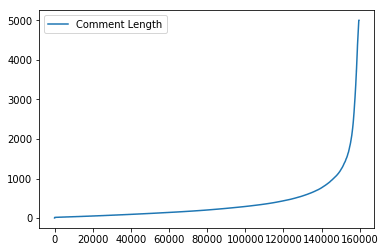

In [4]:
# plot length of texts
def plotlist(l, lbl):
    x = range(len(l))
    plt.plot(x, l, label=lbl)
    plt.legend()
    plt.show()

plotlist(sorted([len(x) for x in train["comment_text"]]), "Comment Length")

In [5]:
# check some texts
for i in range(10):
    print(train["comment_text"][i])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want 

In [6]:
# print number of each text type
vals = {}
for c in columns:
    print("%-35s" % ("Total " + c.title() + " comments:"), train[c].sum())

Total Toxic comments:               15294
Total Severe_Toxic comments:        1595
Total Obscene comments:             8449
Total Threat comments:              478
Total Insult comments:              7877
Total Identity_Hate comments:       1405


In [7]:
# find spam by calculating unique words of a text
spam = []
for t in train["comment_text"]:
    unique_len = len(set(t.split()))
    all_len = len(t.split())
    perc = int(unique_len*100 / all_len)
    if perc < 40:
        spam.append(t)

print("Total spam:", len(spam))
[t[:150]+'...' for t in spam[:40]]

Total spam: 580


['2010 Meet a Local - Vietnam TV Series, Factual / Documentary, 60mins\n\n2010 Meet a Local - Spain TV Series, Factual / Documentary, 60mins\n\n2009 Meet a ...',
 "Other Bush articles not referenced in George W. Bush\nNone of the following articles is mentioned in the George W. Bush and perhaps should be:\n Bush's ...",
 '"\n\nOrphaned non-free image (Image:KSV Hessen Kassel.png)\n Thanks for uploading Image:KSV Hessen Kassel.png. The image description page currently speci...',
 'I AM GAY\nLove\n  \nI AM GAY\nLove\n  \nI AM GAY\nLove...',
 'YOUR ARE FUCKING GAY WAD!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...',
 'YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YO...',
 'User:NHRHS2010 is a homo like mitt romney is. \nUser:NHRHS2010 is a homo like mitt romney is.\n User:Enigmaman is a homo like mitt romney

In [8]:
# find invalid large words
invalid = []
for t in train["comment_text"]:
    lrg = [x for x in t.split() if len(x) > 25]
    if lrg:
        invalid.append(lrg)
invalid[:20]

[['Wikipedia:Good_article_nominations#Transport'],
 ['http://www.its.caltech.edu/~atomic/snowcrystals/myths/myths.htm#perfection'],
 ['(Wikipedia_talk:WikiProject_Classical_music/Archive_5#Need_help.21Wikipedia_talk:WikiProject_Music/Archive_3#I_could_use_some_helpWikipedia_talk:WikiProject_Music/Archive_2#Raulbot.2C_and_the_music_list)',
  'http://digg.com/music/Wikipedia_has_free_classical_music_downloads'],
 ['gays/Gypsys/Slavs/anyone...'],
 ['‘Buckminster-Fuller-carbon-nanotubes’'],
 ['http://www.constitution.ie/reports/ConstitutionofIreland.pdf',
  'http://www.constitution.ie/reports/mbunreachtnaheireann.pdf'],
 ['https://ml.wikipedia.org/wiki/സംവാദം:മോസ്കോ_മെട്രോ.'],
 ['Talk:Jewish_lobby#WP:V_-_comparing_Jewish_Virtual_Library_and_Dissident_Voice.'],
 ['http://www.iranchamber.com/personalities/farabi/farabi.php',
  'http://www.islam.org.br/%C2%A0al_farabi.htm',
  'http://www.superbeyin.com/sohbet/sohbet.htm'],
 ['http://books.google.com/books?id=HHev0U1GfpEC&pg;=PA51&dq;=Thiyya+m

## Cleaning Texts
Based on the above we can now clean the texts.

In [9]:
# we won't need the dataframe next.
values = {c:train[c] for c in columns}
texts = [t for t in train["comment_text"]]
del train
len(texts), len(values["toxic"])

(159571, 159571)

In [10]:
# replace newlines  and convert texts to lower case
texts = [text.replace("\n", " ") for text in texts]

In [11]:
# remove large words
for i in range(len(texts)):
    texts[i] = " ".join([w for w in texts[i].split() if len(w) < 25])

In [12]:
# remove duplicates
tmp = set([x for x, count in collections.Counter(texts).items() if count == 1])
tmp = [i for i, x in enumerate(texts) if x in tmp]
texts = [texts[i] for i in tmp]
for c in columns:
    values[c] = [values[c][i] for i in tmp]
len(texts), len(values["toxic"])

(159023, 159023)

In [13]:
# convert texts to list of words and back to text
# ex: "Hi my name's shady." -> "Hi my name 's shady ."
from nltk.tokenize import word_tokenize
texts = [" ".join(word_tokenize(x)) for x in texts]

In [14]:
# remove special chars except this -> '
texts = [re.sub(r"[^A-Za-z0-9']+", " ", text) for text in texts]

In [15]:
# lemmatization and stemming
# ex: ponies -> poni, cats -> cat
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer 

lem = WordNetLemmatizer()
stem = PorterStemmer()

for i, text in enumerate(texts):
    texts[i] = " ".join([stem.stem(lem.lemmatize(word, "v")) for word in text.split()])
    print(str(100*i/len(texts))[:4], end="\r")

In [16]:
# remove clean comments with length greater than 4000
# (we already have too much clean comments)

clean_ind = {}
for i in range(len(texts)):
    s = 0
    for c in columns:
        s += values[c][i]
    if s == 0:
        clean_ind[i] = True

tmp = [i for i, t in enumerate(texts) if not(i in clean_ind and len(t) > 4000)]

texts = [texts[i] for i in tmp]
for c in columns:
    values[c] = [values[c][i] for i in tmp]
len(texts)

158598

In [17]:
# convert texts to lowercase
texts = [t.lower() for t in texts]

In [18]:
# fix spelling mistakes on the mother of toxic words
rep = {
    "[f]+[u]+[c]+[k]+": "fuck",
    "fukc": "fuck",
    "fcuk": "fuck",
    "nlgga": "nigga"
}

regex = re.compile("(%s)" % "|".join(map(re.escape, rep.keys()))) # single pass to replace
texts = [regex.sub(lambda mo: rep[mo.string[mo.start():mo.end()]], text) for text in texts]

In [19]:
# remove texts with length lower than 6
tmp = [i for i, text in enumerate(texts) if len(text) >= 5]
texts = [texts[i] for i in tmp]
for c in columns:
    values[c] = [values[c][i] for i in tmp]

## Testing
Let's check what we've done so far by creating our tfidfvectorizer and our classifier.

*I've picked those with that parameters after a lot testing.*

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.80,
    ngram_range=(1,2),
    smooth_idf=False,
    sublinear_tf=True
)

vectors = vectorizer.fit_transform(texts)

In [21]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(
    loss="log",
    penalty="l1",
    alpha=5**-8,
    max_iter=15,
    n_jobs=-1,
    random_state=42
)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

raucs = []
accuracies = []

for c in columns:
    X_train, X_test, y_train, y_test = train_test_split(
        vectors,
        values[c],
        test_size=0.20,
        random_state=42
    )
    
    classifier.fit(X_train, y_train)
    predictions = classifier.predict_proba(X_test)
    
    rauc = roc_auc_score(y_test, predictions[:,1])
    raucs.append(rauc)
    
    acc = classifier.score(X_test, y_test)
    accuracies.append(acc)

    print("%-20s" % (c+" | Rauc"), rauc)
    print("%-20s" % (c+" | Accuracy"), acc, "\n")

print("Average accuracy: ", sum(accuracies)/len(accuracies))
print("Average RAUC: ", sum(raucs)/len(raucs))

toxic | Rauc         0.9766660523785413
toxic | Accuracy     0.9609333123127858 

severe_toxic | Rauc  0.9860976152690811
severe_toxic | Accuracy 0.9892479899101372 

obscene | Rauc       0.987275908649174
obscene | Accuracy   0.979221188711966 

threat | Rauc        0.980603453520318
threat | Accuracy    0.9971622260759893 

insult | Rauc        0.9812472963012306
insult | Accuracy    0.9712123600819801 

identity_hate | Rauc 0.9809773516112635
identity_hate | Accuracy 0.99265331861895 

Average accuracy:  0.9817383992853013
Average RAUC:  0.9821446129549348


## Applying on test dataset
Before applying we need to clean the train dataset using the same method we used on cleaning train dataset.

In [23]:
def clean(text):
    text = text.replace("\n", " ")
    text = " ".join(word_tokenize(text))
    text = re.sub(r"[^A-Za-z0-9']+", " ", text)
    text = " ".join([stem.stem(lem.lemmatize(word, "v")) for word in text.split()])
    text = text.lower()
    text = regex.sub(lambda mo: rep[mo.string[mo.start():mo.end()]], text)
    return text

test = pd.read_csv('./test.csv')
texts = [clean(text) for text in test["comment_text"]]
test_vectors = vectorizer.transform(texts)
predictions = {}

for c in columns:
    print("Fit", c)
    classifier.fit(vectors, values[c])
    predictions[c] = classifier.predict_proba(vectors)

with open("./submission-toxic.csv", "w") as f:
    f.write("id,toxic,severe_toxic,obscene,threat,insult,identity_hate\n")
    for i in range(len(test)):
        uid=test["id"][i]
        vals = ",".join([str(predictions[c][i][1]) for c in columns])
        f.write(uid + "," + vals + "\n")

print("CREATED ./submission-toxic.csv")

Fit toxic
Fit severe_toxic
Fit obscene
Fit threat
Fit insult
Fit identity_hate
CREATED ./submission-toxic.csv


## Results
This submission scored `0.9774` RAUC on kaggle. At the date of submission my position was 693/1827

## Notes
Other things I tried but without good results.
- Remove spam comments
- Fix words spelling
- Create a new train set using the predictions
- Other classifiers
- Other vectorizers
- Combining words and char vectorizers
- Remove numbers

All of the above gave me about `-0.01` rmse (except classifiers and vectorizers which gave worst results).